# <span style="color:blue;">Notebook Contents</span>

## 1. Importing Packages

## 2. Data Extraction and Exploration
  1. **Data hygiene checks** 
  2. **Tokenization and Data Exploration**

## 3. Data Preparation
  1. **Creating Train, Validation and Test data sets** 
  2. **Saving the data sets for Model Training and Evaluating**
  
<hr>

## 1. Importing packages

In [1]:
# common imports
import os
import time
from collections import Counter
import pandas as pd
import numpy as np

# for pretty plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure',figsize=(8,6))

In [2]:
# Ingore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 2. Data Extraction and Exploration

In [3]:
file_path = './data/SMSSpamCollection' # path
df = pd.read_csv(file_path, sep='\t', header = None, names = ['Label', 'Message'])

### 2.1 Data hygiene checks

In [4]:
print(df.head()) # print the top 5 rows

  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
df.shape # data size

(5572, 2)

In [6]:
df['Label'].value_counts() # count of classification variable

Label
ham     4825
spam     747
Name: count, dtype: int64

In [7]:
split = df.groupby(['Label']).count()/df.shape[0]  # proportions of spam vs ham
split

,Message
Label,
ham,0.865937
spam,0.134063


In [8]:
spam = split.iloc[1, 0]

In [9]:
print(f'The % of spam in the data is : {spam * 100:.1f}, the rest is ham.')

The % of spam in the data is : 13.4, the rest is ham.


In [10]:
df.info() # data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [11]:
df.isnull().sum()

Label      0
Message    0
dtype: int64

In [12]:
null_values = df.isnull().sum().sum() # check for null values
print(f'The count of null values is : {null_values}')

The count of null values is : 0


In [13]:
df['Length'] = df['Message'].apply(len)
df.head()

,Label,Message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Reading a few messages

In [14]:
spam_messages = df[df["Label"] == "spam"].head(10)["Message"]

ham_messages = df[df["Label"] == "ham"].head(10)["Message"]

print("First 10 Spam Messages:\n")
for msg in spam_messages:
    print(msg)
    
print("-" * 50)  

print("\nFirst 10 Ham Messages:\n")
for msg in ham_messages:
    print(msg)
    

First 10 Spam Messages:

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
XXXMobileMovieClub: To use your credit, click the WAP link in the

#### Length of messages

In [15]:
stats = df.groupby('Label')['Length'].agg(['min', 'max', 'mean'])
stats['mean'] = stats['mean'].round(0)

In [16]:
print(f'Length of messages by type of email :')
print(stats)

Length of messages by type of email :
       min  max   mean
Label                 
ham      2  910   71.0
spam    13  223  139.0


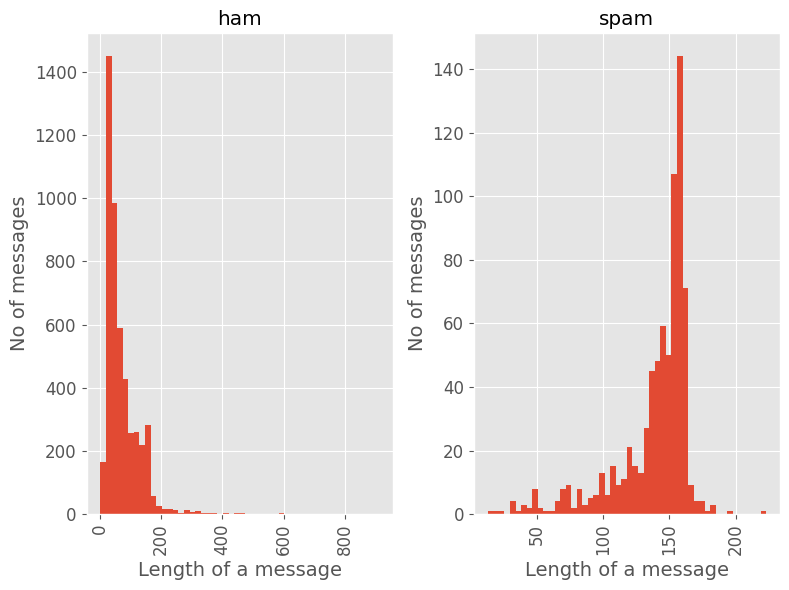

In [17]:
plots = df.hist(column='Length', by='Label', bins=50, figsize=(8,6));

for plot in plots:
    plot.set_xlabel('Length of a message')
    plot.set_ylabel('No of messages')

plt.tight_layout()
plt.show()


### <div style="color:green;">Observations</div>

<hr>

<div style="color:green;">
    <ul>
        <li>There are no null values.</li>
        <li>The message length on average indicates that there are enough characters per message.</li>
        <li>Spam messages have higher no of words on an average and the length of message is more clustered towards the mean.</li>
    </ul>
</div>
<hr>

## 2.2 Tokenization and Data Exploration

In [18]:
# NLP packages
import spacy
from spacy.lang.en import stop_words

In [19]:
nlp = spacy.load('en_core_web_sm') # load spacy english language small model

In [20]:
custom_stop_words = {"u", "ur"}
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

In [21]:
# convert text to tokens and remove non alpha numeric and stop words
def tokenize(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
    return tokens

In [22]:
print(df.iloc[3,1]) # random check
print(tokenize(df.iloc[3,1]))

U dun say so early hor... U c already then say...
['dun', 'early', 'hor', 'c']


In [23]:
# Add tokens to df
df['Tokens'] = df['Message'].apply(tokenize)

In [24]:
df.head()

,Label,Message,Length,Tokens
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[jurong, point, crazy, available, bugis, n, gr..."
1,ham,Ok lar... Joking wif u oni...,29,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,"[dun, early, hor, c]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[nah, think, goes, usf, lives]"


In [25]:
df['Tokens'].head()

0    [jurong, point, crazy, available, bugis, n, gr...
1                          [ok, lar, joking, wif, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3                                 [dun, early, hor, c]
4                       [nah, think, goes, usf, lives]
Name: Tokens, dtype: object

In [26]:
# common words by spam vs ham
grouped_tokens = df.groupby('Label')['Tokens'].sum()

high_freq_words = {}
low_freq_words = {}

for label, tokens in grouped_tokens.items():
    word_counts = Counter(tokens)
    high_freq_words[label] = word_counts.most_common(20)
    low_freq_words[label] = word_counts.most_common()[:-21:-1]

# display
for label, words in high_freq_words.items():
    print(f"Top words in '{label}':")
    for word, count in words:
        print(f"{word}: {count}")
    print("\n")

Top words in 'ham':
nt: 319
ok: 278
got: 245
know: 235
like: 232
come: 229
good: 227
day: 198
love: 193
time: 191
going: 168
ü: 167
want: 165
lor: 162
home: 160
need: 157
sorry: 157
n: 144
today: 136
da: 136


Top words in 'spam':
free: 223
txt: 154
mobile: 127
text: 123
stop: 120
claim: 113
reply: 101
prize: 92
cash: 76
won: 73
send: 70
new: 69
nokia: 66
urgent: 63
win: 60
week: 60
tone: 59
service: 56
contact: 56
guaranteed: 50




In [27]:
# identifying common words
labels = list(high_freq_words.keys())

words_ham = [word for word,_ in high_freq_words[labels[0]]]
words_spam = [word for word,_ in high_freq_words[labels[1]]]

common_words = set(words_ham) & set(words_spam)

print(common_words)

set()


### <div style="color:green;">Observations</div>

<hr>
<div style="color:green;">
    <ul>
        <li>High frequency words are not overlapping between the two classes.</li>
        <li>This can make rule-based predictions viable.</li>
    </ul>
</div>
<hr>

## 3. Data Preparation

### 3.1 Creating Train, Validation and Test data sets

In [28]:
# Model selection
from sklearn.model_selection import train_test_split

In [29]:
def dataSets(dataframe):
    '''
    This function returns the train, validation and test datasets. 
    Along with returning these datasets it will also print the
    class representation across datasets.
    '''
    train_val, test = train_test_split(dataframe, test_size = 0.2, random_state = 42, stratify = dataframe['Label'])
    tr, val = train_test_split(train_val, test_size = 0.2, random_state = 42, stratify = train_val['Label'])
    
    tr_distribution = tr['Label'].value_counts(normalize=True).mul(100).round(1)
    print(f"\nNo of samples in train data : {len(tr)}")
    print(f"Train data class distribution % :")
    print(tr_distribution)

    val_distribution = val['Label'].value_counts(normalize=True).mul(100).round(1)
    print(f"\nNo of samples in validation data : {len(val)}")
    print(f"Validation data class distribution % :")
    print(val_distribution)

    test_distribution = test['Label'].value_counts(normalize=True).mul(100).round(1)
    print(f"\nNo of samples in test data : {len(test)}")
    print(f"Test data class distribution % :")
    print(test_distribution)

    return tr, val, test

In [30]:
train, validation, test = dataSets(df)


No of samples in train data : 3565
Train data class distribution % :
Label
ham     86.6
spam    13.4
Name: proportion, dtype: float64

No of samples in validation data : 892
Validation data class distribution % :
Label
ham     86.5
spam    13.5
Name: proportion, dtype: float64

No of samples in test data : 1115
Test data class distribution % :
Label
ham     86.6
spam    13.4
Name: proportion, dtype: float64


### 3.2 Saving the data sets for Model Training and Evaluating

In [31]:
train.to_csv('./data/train.csv', index=False)
validation.to_csv('./data/validation.csv', index=False)
test.to_csv('./data/test.csv', index=False)